In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from keras.utils import to_categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from tqdm.notebook import tqdm

## put all the the weird stuff below 
from matplotlib.patches import Circle, PathPatch

Using TensorFlow backend.


## A simple linear model would be enough for the job

<img src = "images/iris_nn.png" width = "400">

In [2]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,2)

        self.layer2 = nn.Linear(2, 5)
        self.layer3 = nn.Linear(5, 3)
        self.first_layer_first_label_op = None

        
    def forward(self, x, interpolation_vals = None):
        x = self.layer1(x)

        if interpolation_vals is not None:
            x[0] = torch.FloatTensor(interpolation_vals)  ## list [1,2]
            # print("hardcoded valuees  to = ", x[0])
  
        self.first_layer_first_label_op = x[0].detach().numpy()

            

        x = F.relu(x)
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim = 1) # To check with the loss function
        return x, self.first_layer_first_label_op

In [75]:
features, labels = load_iris(return_X_y=True)

In [22]:

def create_interpolation(model, lower_x, upper_x, lower_y, upper_y, step_x, step_y, x_train , loss_fn = nn.CrossEntropyLoss() ):

    losses = []
    layer_1_outputs = []
    xs = np.arange(lower_x,upper_x+step_x, step_x)
    ys = np.arange(lower_y,upper_y+step_y, step_y)

    for x in tqdm(xs):
        for y in ys:
            y_pred,  intermediate_output_layer_1 = model(x_train, interpolation_vals = [x,y])

            layer_1_outputs.append(intermediate_output_layer_1)

            # print (intermediate_output_layer_1)
            loss = loss_fn(y_pred, y_train)
            losses.append(loss.item())

    ops =  np.array(layer_1_outputs)
    x_vals = ops[:,0].tolist()
    y_vals = ops[:,1].tolist()
    z_vals = losses

    return x_vals, y_vals, z_vals

def list_to_surface(x,y,z, num_steps):
    plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),num_steps),\
                           np.linspace(np.min(Y),np.max(Y),num_steps))
    plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')
    return plotx, ploty, plotz

In [76]:
n_columns =2
features_2 = features[:,: n_columns]
x_train, y_train = Variable(torch.from_numpy(features_2)).float(), Variable(torch.from_numpy(labels)).long()

model = Model(input_dim = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [77]:
def train_model(epochs, model, x_train, y_train):

    losses = []
    layer_1_outputs = []

    for epoch in range(1, epochs+1):
        y_pred,  intermediate_output_layer_1 = model(x_train)
        layer_1_outputs.append(intermediate_output_layer_1)
        loss = loss_fn(y_pred, y_train)
        losses.append(loss.item())
        # Zero gradients
        optimizer.zero_grad()
        loss.backward() # Gradients
        optimizer.step() # Update

    plt.plot(losses, label = "loss")
    plt.legend()
    plt.grid()
    plt.show()

    return losses, layer_1_outputs

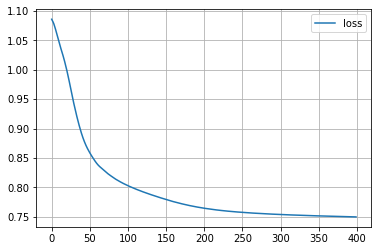

In [78]:
losses, layer_1_outputs = train_model(epochs = 400, model = model, x_train = x_train, y_train = y_train )

In [ ]:
x_vals, y_vals, z_vals = create_interpolation(model = model, 
                                              lower_x = -0,
                                              upper_x = 5,
                                              lower_y = -2,
                                              upper_y = 15,
                                              step_x = 0.2,
                                              step_y = 0.2,
                                              x_train = x_train,
                                            )

In [ ]:
X = x_vals
Y = y_vals
Z = z_vals
plotx, ploty,plotz = list_to_surface(X,Y,Z, 10)

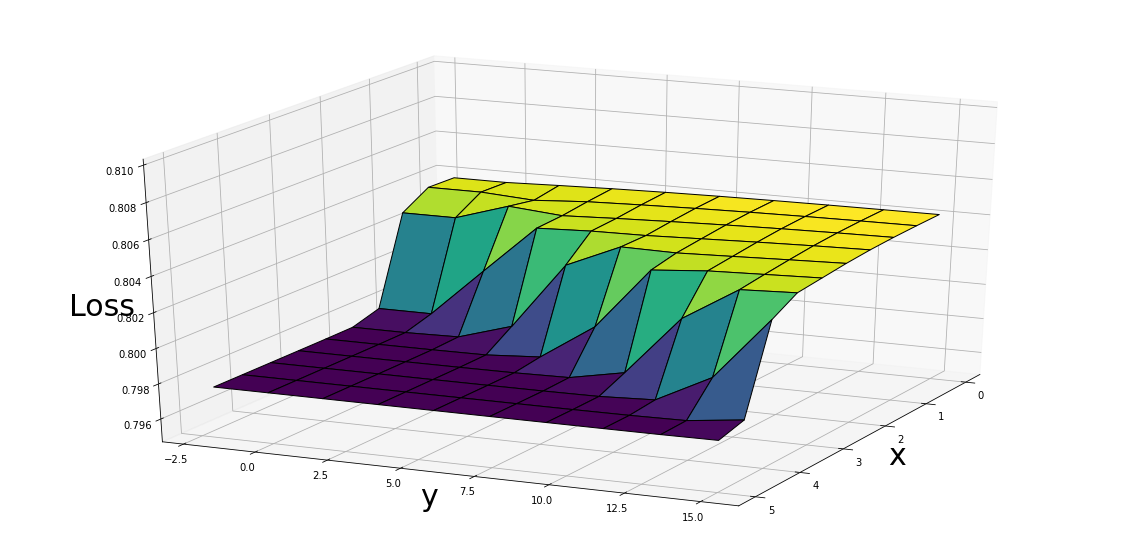

In [ ]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap = "viridis", edgecolor = "black")  # or 'hot'

ax.view_init(25, 25)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('y', fontsize = 30)
ax.set_zlabel('Loss', fontsize = 30)
ax.set_zlim(0.795, 0.81)
fig.show()

## Building another architecture with a bottleneck in the end 

This time on all the columns 

In [103]:
class Model_bottleneck(nn.Module):
    def __init__(self, input_dim):
        super(Model_bottleneck, self).__init__()
        self.layer1 = nn.Linear(input_dim,10)
        self.layer2 = nn.Linear(10, 45)
        self.layer3 = nn.Linear(45, 25)
        self.layer4 = nn.Linear(25, 2)
        self.layer5 = nn.Linear(2, 10)
        self.layer6 = nn.Linear(10, 25)
        self.layer7 = nn.Linear(25, 20)
        self.layer8 = nn.Linear(20, 3)

        self.first_layer_first_label_op = None

    def forward(self, x, interpolation_vals = None):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))

        if interpolation_vals is not None:
            x[0] = torch.FloatTensor(interpolation_vals)  ## list [1,2]
            # print("hardcoded valuees  to = ", x[0])
  
        self.first_layer_first_label_op = x[0].detach().numpy()

        x = F.relu(self.layer5(x))
        x = F.relu(self.layer6(x))
        x = F.relu(self.layer7(x))
        x = F.softmax(self.layer8(x), dim = 1)

        return x, self.first_layer_first_label_op

In [104]:
n_columns =4
features = features[:,: n_columns]
x_train, y_train = Variable(torch.from_numpy(features)).float(), Variable(torch.from_numpy(labels)).long()

In [111]:
model_2 = Model_bottleneck(input_dim = 4)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
print(model_2)

Model_bottleneck(
  (layer1): Linear(in_features=4, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=45, bias=True)
  (layer3): Linear(in_features=45, out_features=25, bias=True)
  (layer4): Linear(in_features=25, out_features=2, bias=True)
  (layer5): Linear(in_features=2, out_features=10, bias=True)
  (layer6): Linear(in_features=10, out_features=25, bias=True)
  (layer7): Linear(in_features=25, out_features=20, bias=True)
  (layer8): Linear(in_features=20, out_features=3, bias=True)
)


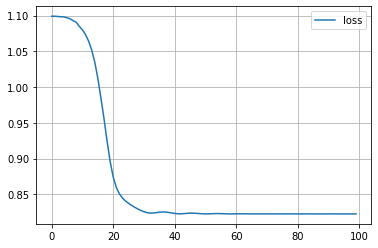

In [112]:
losses, bottleneck_layer_outputs = train_model(epochs = 100, model = model_2, x_train = x_train, y_train = y_train )

In [ ]:
x_vals, y_vals, z_vals = create_interpolation(model = model_2, 
                                              lower_x = -5,
                                              upper_x = 30,
                                              lower_y = -20,
                                              upper_y = 30,
                                              step_x = 0.3,
                                              step_y = 0.3,
                                              x_train = x_train,
                                            )

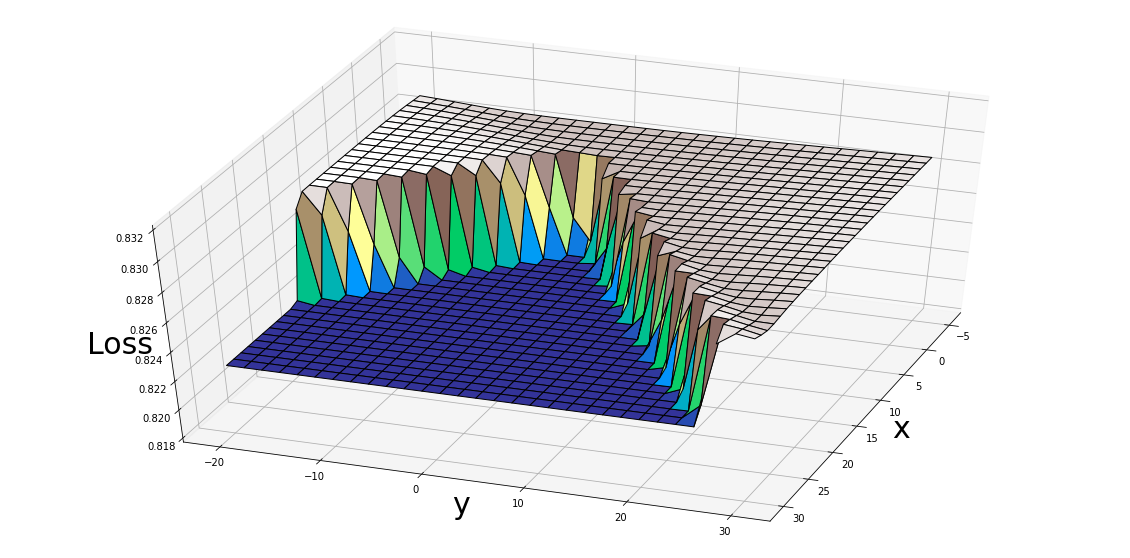

In [149]:
X = x_vals
Y = y_vals
Z = z_vals
plotx, ploty,plotz = list_to_surface(X,Y,Z, 30)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap = "terrain", edgecolor = "black")  # or 'hot'

ax.view_init(45,20)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('y', fontsize = 30)
ax.set_zlabel('Loss', fontsize = 30)
ax.set_zlim(0.818, 0.832)

fig.show()

## Time to add some trees to make it look less like an alien planet

In [212]:
def data_for_cylinder_along_z(center_x,center_y, bottom_z,radius,height_z):
    z = np.linspace(bottom_z, bottom_z + height_z, 10)
    theta = np.linspace(0, 2*np.pi, 10)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

In [312]:
def draw_tree_on_3d_plot(ax, x,y,z, brown_radius, brown_height, green_radius, green_height):
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x = x,
                                     center_y = y,
                                     bottom_z = z, 
                                     radius = brown_radius,
                                     height_z = brown_height)
    ax.plot_surface(Xc, Yc, Zc, alpha=1, edgecolor = "black")

    Xc,Yc,Zc = data_for_cylinder_along_z(center_x = x,
                                        center_y = y,
                                        bottom_z = z + brown_height, 
                                        radius = green_radius,
                                        height_z = green_height)
    ax.plot_surface(Xc, Yc, Zc, alpha=1, edgecolor = "black")
    return ax

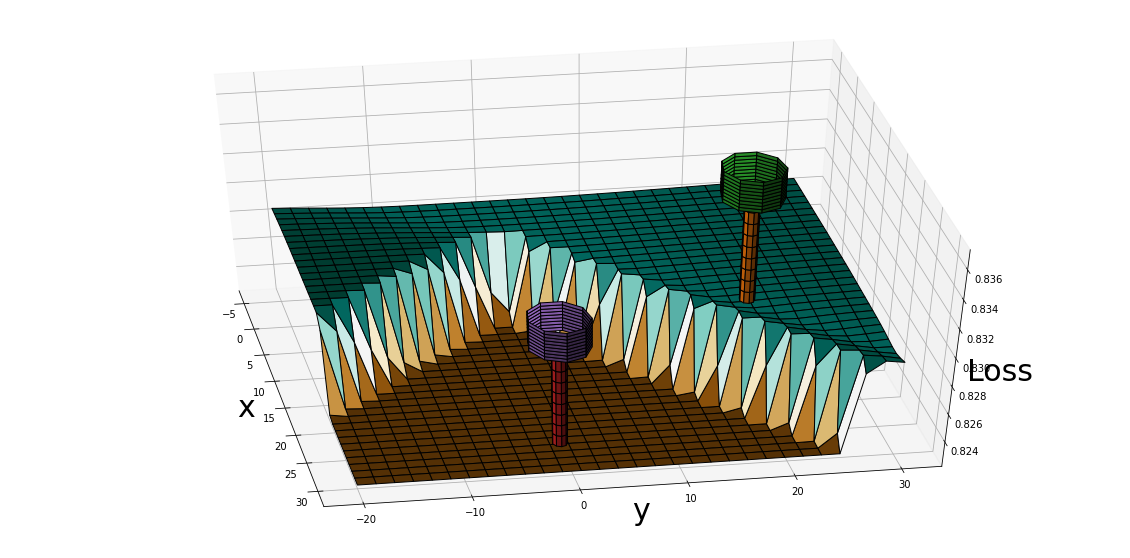

In [330]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap = "BrBG", edgecolor = "black")  # or 'hot'

ax = draw_tree_on_3d_plot(ax, 
                     x = 15,
                     y = 20,
                     z = 0.828, 
                     brown_radius = 0.7, 
                     brown_height = 0.007, 
                     green_radius = 2.9, 
                     green_height = 0.002)

ax = draw_tree_on_3d_plot(ax, 
                     x = 25,
                     y = 0,
                     z = 0.8225, 
                     brown_radius = 0.7, 
                     brown_height = 0.007, 
                     green_radius = 2.9, 
                     green_height = 0.002)

ax.view_init(45,-10)
ax.set_xlabel('x', fontsize = 30)
ax.set_ylabel('y', fontsize = 30)
ax.set_zlabel('Loss', fontsize = 30)
# ax.set_zlim(0.818, 0.832)

fig.show()